In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import rebound as rb

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

In [6]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
    df[c] = pd.to_numeric(df[c])

df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


In [7]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [8]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1249051, 21), (1249051, 11))

In [ ]:
sim = rb.Simulation('planets.bin')
# sim = rb.Simulation()
# sim.add("Sun")
# sim.add("Jupiter")
# sim.add("Saturn")
# sim.add("Uranus")
# sim.add("Neptune")

# sim.move_to_com()

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulation.py:153: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


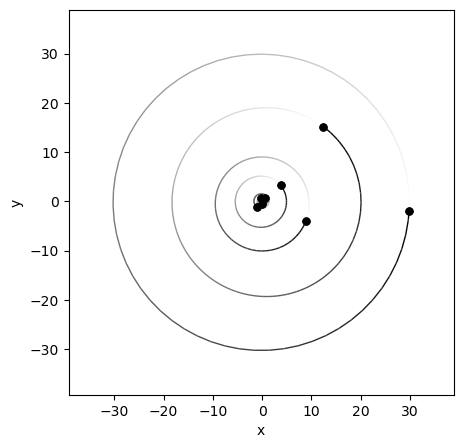

In [27]:
rb.OrbitPlot(sim)

In [28]:
row = merged_df.iloc[0]
row

Des'n           00001
H_x              3.34
G                0.15
Epoch           K239D
M            60.07879
Peri.        73.42179
Node         80.25496
Incl.        10.58688
e            0.078913
n           .21410680
a            2.767254
propa        2.767028
da           0.000023
prope        0.115193
de            0.00016
propsini      0.16756
dsini        0.000013
g             54.2538
s          -59.249995
H_y              3.34
NumOpps           123
Name: 0, dtype: object

In [29]:
sim = rb.Simulation('planets.bin')
sim.add(a=row['a'], e=row['e'], inc=row['Incl.'], Omega=row['Node'], omega=row['Peri.'], M=row['M'], primary=sim.particles[0])

# sim = rb.Simulation()
# sim.add("Sun")
# sim.add("Jupiter")
# sim.add("Saturn")
# sim.add("Uranus")
# sim.add("Neptune")

# sim.add(a=row['a'], e=row['e'], inc=row['Incl.'], Omega=row['Node'], omega=row['Peri.'], M=row['M'], primary=sim.particles[0])
# sim.move_to_com()

In [31]:
ps = sim.particles
ps[-1].a

2.765701098386202

In [32]:
Nout = int(10000*np.pi)
times = np.linspace(0, 5e6*ps[-1].P, Nout)
sim.integrator='whfast'
sim.dt = ps[1].P/20
a = np.zeros(Nout)

In [33]:
%%time
for i, time in enumerate(times):
    sim.integrate(time)
    orb = ps[-1].orbit(primary=sim.particles[0])
    a[i] = orb.a

KeyboardInterrupt: 

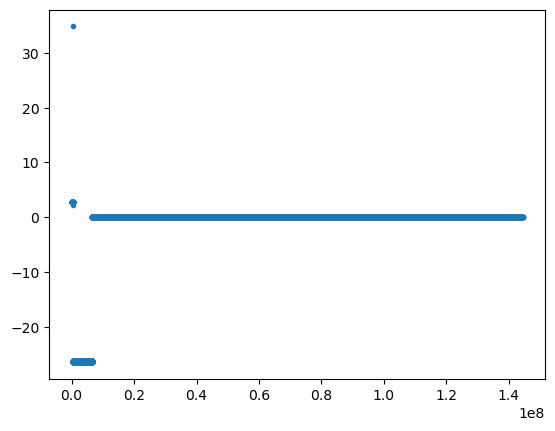

In [34]:
fig, ax = plt.subplots()
ax.plot(times, a, '.')

In [34]:
a.mean()


2.733319532407503

In [36]:
merged_df.iloc[0]['propa']

2.767028